In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils

In [ ]:
from pyomo.environ import *
import numpy as np

Defining Parameters

In [ ]:
P_max = np.array([75,50,100])
P_max

array([ 75,  50, 100])

In [ ]:
demand = 50 + 150*(np.random.rand(24))
demand

array([ 97.84842609, 139.93108572, 166.49524957, 193.6544347 ,
       154.26937902, 178.64706474,  70.47771021, 101.62842885,
        82.21981854, 154.98247126,  82.0471033 , 145.65920377,
        66.1238456 , 132.24014275,  66.1057766 , 155.15553943,
       104.40012084,  74.85178515, 109.32892403, 116.94847811,
       126.05074763, 134.08098626,  62.00900114, 174.41564056])

In [ ]:
Cost_NL = 5 * (np.random.rand(3))
Cost_s = 7 * (np.random.rand(3))
Cost_p = 10 * (np.random.rand(3))

Defining Model

In [ ]:
model = ConcreteModel()

Defining sets

In [ ]:
model.T=Set(initialize=range(24)) #timeslot
model.G=Set(initialize=range(3))  #generators

Defining variables

In [ ]:
model.p = Var(model.G,model.T,within = NonNegativeReals)
model.u_start = Var(model.G,model.T, within = Binary)
model.u_state = Var(model.G,model.T, within = Binary)

In [ ]:
def c1(model,t):
    return sum([model.p[g,t] for g in model.G]) == demand[t]

def c2(model, g, t):
    return model.p[g,t] <= model.u_state[g,t]*P_max[g]

def c3(model, g, t):
    if t >= 1:
        return model.u_state[g,t] - model.u_state[g,t-1] <= model.u_state[g,t] 
    else:
        return model.u_state[g,t] <= model.u_state[g,t]

model.Con1 = Constraint(model.T, rule=c1) 
model.Con2 = Constraint(model.G, model.T, rule=c2)
model.Con3 = Constraint(model.G, model.T, rule=c3)

In [ ]:
def obj(model):
  return sum(sum(Cost_p[g]*model.p[g,t] + Cost_s[g]*model.u_start[g,t] + Cost_NL[g]*model.u_state[g,t] for g in model.G) for t in model.T)
model.OF = Objective(rule=obj, sense=minimize)

In [ ]:
solver = SolverFactory('glpk')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 12630.1450493989, 'Upper bound': 12630.1450493989, 'Number of objectives': 1, 'Number of constraints': 169, 'Number of variables': 217, 'Number of nonzeros': 286, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '19', 'Number of created subproblems': '19'}}, 'Error rc': 0, 'Time': 0.015308141708374023}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

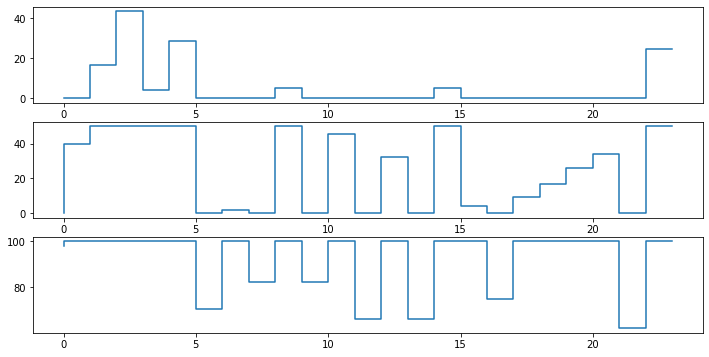

In [ ]:
P = np.zeros((3,24))

for g in range(3):
    P[g] = [np.round(model.p[g,t].value,3) for t in range(24)]
    
G = pd.DataFrame(P, index=['G1','G2','G3'])
G    
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.step(range(0,24),P[0])
plt.subplot(3,1,2)
plt.step(range(0,24),P[1])
plt.subplot(3,1,3)
plt.step(range(0,24),P[2])

plt.show()